# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings


# Configs

In [2]:
LABELED_PATH = "../data/results/labels.parquet"
PREDICTED_XGB_PATH = "../data/results/xgb_prediction_labeled.parquet"
PREDICTED_XGB_ARIMA_PATH = "../data/results/xgb_predictions.parquet"
PREDICTED_REGRESSION_PATH = "../data/results/ridge_predictions.parquet"
PREDICTED_ARIMA_PATH = "../data/results/arima_predict.parquet"
TEST_START_DATE = '2023-04-01'
IMPORTANT_LOCATIONS = 50
warnings.filterwarnings('ignore')

In [3]:
predictions_dict = {
    'baseline_last_day':None,
    'baseline_last_week':None,
    'arima':None,
    'model_regression':None,
    'model_xgboost':None,
    'model_xgboost_arima':None,
}

In [4]:
sorted_locations_dict={
    'baseline_last_day':None,
    'baseline_last_week':None,
    'arima':None,
    'model_regression':None,
    'model_xgboost':None,
    'model_xgboost_arima':None,
}

In [5]:
predictions_mean_error_dict={
    'baseline_last_day':
    {
        'Location':
                {
                'Important_loc':None,
                'Others_loc':None,
                'All_loc':None
                },
        'Date':
                {
                'Important_loc':None,
                'Others_loc':None,
                'All_loc':None
                },
        'day_of_week':
                {
                'Important_loc':None,
                'Others_loc':None,
                'All_loc':None
                }
    },
    'baseline_last_week':
    {
        'Location':
                {
                'Important_loc':None,
                'Others_loc':None,
                'All_loc':None
                },
        'Date':
                {
                'Important_loc':None,
                'Others_loc':None,
                'All_loc':None
                },
        'day_of_week':
                {
                'Important_loc':None,
                'Others_loc':None,
                'All_loc':None
                }
    },
    'arima':
    {
        'Location':
                {
                'Important_loc':None,
                'Others_loc':None,
                'All_loc':None
                },
        'Date':
                {
                'Important_loc':None,
                'Others_loc':None,
                'All_loc':None
                },
        'day_of_week':
                {
                'Important_loc':None,
                'Others_loc':None,
                'All_loc':None
                }
    },
    'model_regression':
    {
        'Location':
                {
                'Important_loc':None,
                'Others_loc':None,
                'All_loc':None
                },
        'Date':
                {
                'Important_loc':None,
                'Others_loc':None,
                'All_loc':None
                },
        'day_of_week':
                {
                'Important_loc':None,
                'Others_loc':None,
                'All_loc':None
                }
    },
    'model_xgboost':
    {
        'Location':
                {
                'Important_loc':None,
                'Others_loc':None,
                'All_loc':None
                },
        'Date':
                {
                'Important_loc':None,
                'Others_loc':None,
                'All_loc':None
                },
        'day_of_week':
                {
                'Important_loc':None,
                'Others_loc':None,
                'All_loc':None
                }
    },
    'model_xgboost_arima':
    {
        'Location':
                {
                'Important_loc':None,
                'Others_loc':None,
                'All_loc':None
                },
        'Date':
                {
                'Important_loc':None,
                'Others_loc':None,
                'All_loc':None
                },
        'day_of_week':
                {
                'Important_loc':None,
                'Others_loc':None,
                'All_loc':None
                }
    },
}

# Load Data

## Load labeled data

In [6]:
labeled_df = pd.read_parquet(LABELED_PATH)
print(labeled_df.shape)
labeled_df.head()

(31440, 3)


,Location,Date,Demand
0,1,2023-01-01,40.0
1,1,2023-01-02,31.0
2,1,2023-01-03,27.0
3,1,2023-01-04,7.0
4,1,2023-01-05,15.0


In [7]:
test_df = labeled_df.loc[labeled_df['Date']>=TEST_START_DATE]
test_df = test_df.reset_index(drop = True)
test_df.head()

,Location,Date,Demand
0,1,2023-04-01,13.0
1,1,2023-04-02,17.0
2,1,2023-04-03,9.0
3,1,2023-04-04,12.0
4,1,2023-04-05,18.0


## Load Predicted Data

In [8]:
predictions_dict['model_xgboost'] = pd.read_parquet(PREDICTED_XGB_PATH)
predictions_dict['model_xgboost'].head()

,Location,Date,Predicted_demand
0,1,2023-04-01,9.159037
1,1,2023-04-02,5.113592
2,1,2023-04-03,11.624486
3,1,2023-04-04,9.921972
4,1,2023-04-05,7.794608


In [9]:
predictions_dict['model_regression'] = pd.read_parquet(PREDICTED_REGRESSION_PATH)
predictions_dict['model_regression'].head()

,Location,Date,Predicted_demand
0,1,2023-04-01,24.753056
1,1,2023-04-02,26.706262
2,1,2023-04-03,15.639358
3,1,2023-04-04,16.354262
4,1,2023-04-05,14.041562


In [17]:
predictions_dict['arima'] = pd.read_parquet(PREDICTED_ARIMA_PATH)
predictions_dict['arima']['Predicted_demand'] = predictions_dict['arima']['arima_predicted_demand']
predictions_dict['arima'].head()

,Location,Date,arima_predicted_demand,Predicted_demand
0,1,2023-01-15,18,18
1,1,2023-01-16,18,18
2,1,2023-01-17,19,19
3,1,2023-01-18,17,17
4,1,2023-01-19,12,12


In [11]:
predictions_dict['model_xgboost_arima'] = pd.read_parquet(PREDICTED_XGB_ARIMA_PATH)
predictions_dict['model_xgboost_arima'].head()

,Location,Date,Predicted_demand
0,1,2023-04-01,17.492563
1,1,2023-04-02,19.940285
2,1,2023-04-03,11.534259
3,1,2023-04-04,10.289442
4,1,2023-04-05,10.427998


### BaseLine Models

In [12]:
def baseline_predict(dataset, shift_val):
    predicted_demand = dataset.groupby(['Location'])['Demand'].shift(shift_val)
    predicted_data = pd.DataFrame(dataset[['Location', 'Date']])
    predicted_data['Predicted_demand'] = predicted_demand
    return predicted_data

In [13]:
predictions_dict['baseline_last_day'] = baseline_predict(test_df, 1)
predictions_dict['baseline_last_week'] = baseline_predict(test_df, 7)

### Join Predictions and Actual

In [14]:
def join_actual_predict(actual_df, predicted_df):
    actual_predicted_df = actual_df.copy()
    actual_predicted_df['Predicted_demand'] = predicted_df['Predicted_demand']
    actual_predicted_df = actual_predicted_df.dropna()
    actual_predicted_df['day_of_week'] = actual_predicted_df['Date'].dt.dayofweek
    return actual_predicted_df

In [24]:
predictions_dict['arima'] = join_actual_predict(test_df, predictions_dict['arima'])
predictions_dict['arima'].head()

,Location,Date,Demand,Predicted_demand,day_of_week
0,1,2023-04-01,13.0,18,5
1,1,2023-04-02,17.0,18,6
2,1,2023-04-03,9.0,19,0
3,1,2023-04-04,12.0,17,1
4,1,2023-04-05,18.0,12,2


In [26]:
predictions_dict['baseline_last_week'] = join_actual_predict(test_df,predictions_dict['baseline_last_week'])
predictions_dict['baseline_last_week'].head()

,Location,Date,Demand,Predicted_demand,day_of_week
7,1,2023-04-08,14.0,13.0,5
8,1,2023-04-09,18.0,17.0,6
9,1,2023-04-10,17.0,9.0,0
10,1,2023-04-11,14.0,12.0,1
11,1,2023-04-12,16.0,18.0,2


In [25]:
predictions_dict['baseline_last_day'] = join_actual_predict(test_df,predictions_dict['baseline_last_day'])
predictions_dict['baseline_last_day'].head()

,Location,Date,Demand,Predicted_demand,day_of_week
1,1,2023-04-02,17.0,13.0,6
2,1,2023-04-03,9.0,17.0,0
3,1,2023-04-04,12.0,9.0,1
4,1,2023-04-05,18.0,12.0,2
5,1,2023-04-06,10.0,18.0,3


In [27]:
predictions_dict['model_regression'] = join_actual_predict(test_df,predictions_dict['model_regression'])
predictions_dict['model_regression'].head()

,Location,Date,Demand,Predicted_demand,day_of_week
0,1,2023-04-01,13.0,24.753056,5
1,1,2023-04-02,17.0,26.706262,6
2,1,2023-04-03,9.0,15.639358,0
3,1,2023-04-04,12.0,16.354262,1
4,1,2023-04-05,18.0,14.041562,2


In [28]:
predictions_dict['model_xgboost'] = join_actual_predict(test_df,predictions_dict['model_xgboost'])
predictions_dict['model_xgboost'].head()

,Location,Date,Demand,Predicted_demand,day_of_week
0,1,2023-04-01,13.0,9.159037,5
1,1,2023-04-02,17.0,5.113592,6
2,1,2023-04-03,9.0,11.624486,0
3,1,2023-04-04,12.0,9.921972,1
4,1,2023-04-05,18.0,7.794608,2


In [29]:
predictions_dict['model_xgboost_arima'] = join_actual_predict(test_df,predictions_dict['model_xgboost_arima'])
predictions_dict['model_xgboost_arima'].head()

,Location,Date,Demand,Predicted_demand,day_of_week
0,1,2023-04-01,13.0,17.492563,5
1,1,2023-04-02,17.0,19.940285,6
2,1,2023-04-03,9.0,11.534259,0
3,1,2023-04-04,12.0,10.289442,1
4,1,2023-04-05,18.0,10.427998,2


### Sort Locations by Demand

In [30]:
def sort_locations_on_demand(predictions_dict,sorted_locations_dict):
    for label,predictions_df in predictions_dict.items():
        if (predictions_df is not None):
            sorted_index = predictions_df.groupby('Location')['Demand'].aggregate(['sum']).sort_values('sum', ascending=False)
            sorted_index = sorted_index.reset_index()
            sorted_locations_dict[label] = sorted_index

In [31]:
sort_locations_on_demand(predictions_dict, sorted_locations_dict)
sorted_locations_dict['arima'].head()

,Location,sum
0,132,173355.0
1,237,153779.0
2,161,149098.0
3,236,138316.0
4,142,113448.0


## Mean error Calculation

### Error Columns

In [32]:
def calculate_error(actual_predicted_dict: dict):
    for label,actual_predicted_df in actual_predicted_dict.items():
        if (actual_predicted_df is not None):
            actual_predicted_df['error'] = np.abs(
                actual_predicted_df['Demand']-actual_predicted_df['Predicted_demand']
                )
            actual_Demand_df = np.where(actual_predicted_df['Demand']==0, 1, actual_predicted_df['Demand'])
            actual_predicted_df['percentage_error'] = (
                actual_predicted_df['error']/actual_Demand_df
                )*100
            

In [33]:
calculate_error(predictions_dict)
predictions_dict['arima'].head()

,Location,Date,Demand,Predicted_demand,day_of_week,error,percentage_error
0,1,2023-04-01,13.0,18,5,5.0,38.461538
1,1,2023-04-02,17.0,18,6,1.0,5.882353
2,1,2023-04-03,9.0,19,0,10.0,111.111111
3,1,2023-04-04,12.0,17,1,5.0,41.666667
4,1,2023-04-05,18.0,12,2,6.0,33.333333


### Aggregate Error Columns

In [34]:
def calculate_maen_error(actual_predicted_dict: dict, predictions_mean_dict: dict):
    per_columns=['Location', 'Date', 'day_of_week']
    for model,actual_predicted_df in actual_predicted_dict.items():
        if (actual_predicted_df is not None):
            sorted_index = sorted_locations_dict[model]['Location']
            important_actual_predicted_df = actual_predicted_df.loc[actual_predicted_df['Location'].isin(sorted_index[:IMPORTANT_LOCATIONS])]
            other_actual_predicted_df = actual_predicted_df.loc[~actual_predicted_df['Location'].isin(sorted_index[:IMPORTANT_LOCATIONS])]
            for per in per_columns:
                important_error_df = important_actual_predicted_df[[per,'Demand','error', 'percentage_error',]] 
                others_error_df = other_actual_predicted_df[[per,'Demand','error','percentage_error']] 
                all_error_df = actual_predicted_df[[per,'Demand','error','percentage_error']]
                
                important_mean_df = important_error_df\
                                                .groupby(per)\
                                                .agg(mape=('percentage_error','mean'),
                                                    mae=('error','mean'),
                                                    demand_mean=('Demand','mean')) 
                others_mean_df = others_error_df\
                                                .groupby(per)\
                                                .agg(mape=('percentage_error','mean'),
                                                    mae=('error','mean'),
                                                    demand_mean=('Demand','mean')) 
                all_mean_df = all_error_df\
                                            .groupby(per)\
                                            .agg(mape=('percentage_error','mean'),
                                                mae=('error','mean'),
                                                demand_mean=('Demand','mean')) 
                if per == 'Location':
                    important_mean_df = important_mean_df.reindex(sorted_index[:IMPORTANT_LOCATIONS])

                    others_mean_df = others_mean_df.reindex(sorted_index[IMPORTANT_LOCATIONS:])

                    all_mean_df = all_mean_df.reindex(sorted_index)
                
                predictions_mean_dict[model][per]['Important_loc'] = important_mean_df.reset_index()
                predictions_mean_dict[model][per]['Others_loc'] = others_mean_df.reset_index()
                predictions_mean_dict[model][per]['All_loc'] = all_mean_df.reset_index()
                
    

In [35]:
calculate_maen_error(predictions_dict, predictions_mean_error_dict)

In [36]:
predictions_mean_error_dict['arima']['Location']['All_loc'].head()

,Location,mape,mae,demand_mean
0,132,99.817716,5768.100000,5778.500000
1,237,99.879574,5120.366667,5125.966667
2,161,97.199635,4839.600000,4969.933333
3,236,99.486257,4587.933333,4610.533333
4,142,99.673737,3769.366667,3781.600000


In [37]:
predictions_mean_error_dict['baseline_last_day']['Date']['Important_loc'].head()

,Date,mape,mae,demand_mean
0,2023-04-02,23.951783,455.26,1919.74
1,2023-04-03,32.909363,450.86,1869.88
2,2023-04-04,13.892256,298.18,2097.82
3,2023-04-05,8.732048,178.86,2239.04
4,2023-04-06,13.489201,265.68,2090.48


In [39]:
predictions_mean_error_dict['model_xgboost']['Date']['All_loc'].head()

,Date,mape,mae,demand_mean
0,2023-04-01,81.173439,38.402997,446.568702
1,2023-04-02,138.764470,28.800046,381.206107
2,2023-04-03,329.019898,43.431597,369.904580
3,2023-04-04,40.051021,24.446000,414.461832
4,2023-04-05,41.921261,36.997306,441.412214


### Plot Mape for Models Predicted Demands

In [42]:
def plot_mape(predictions_mean_dict, per):
    
    fig, axes = plt.subplots(nrows=(4 if (per == 'Location') else 3 ), ncols=1, figsize=((15,25)if (per == 'Location') else (15,20))) 
    
    for model,mean_df in predictions_mean_dict.items():
        important_df = mean_df[per]['Important_loc']
        others_df = mean_df[per]['Others_loc']
        all_df = mean_df[per]['All_loc']
        if (important_df is not None) and (others_df is not None):
            important_df[per] = important_df[per].astype(str)
            others_df[per] = others_df[per].astype(str)
            all_df[per] = all_df[per].astype(str)

            important_df.plot(x=per,y='mape',kind='line',marker='.',ax = axes[0], label=model)
            if per == 'Location':
                split_size = len(others_df)//2
                others_df[:split_size].plot(x=per,y='mape',kind='line',marker='.',ax = axes[1],label=model)
                others_df[split_size:].plot(x=per,y='mape',kind='line',marker='.',ax = axes[2],label=model)
                all_df.plot(x=per,y='mae',kind='line',ax = axes[3],label=model)
            else:
                others_df.plot(x=per,y='mape',kind='line',marker='.',ax = axes[1],label=model)
                all_df.plot(x=per,y='mae',kind='line',ax = axes[2],label=model)

    axes[0].set_title('Models MAPE for '+str(IMPORTANT_LOCATIONS)+' imortant locations', bbox=dict( alpha=0.5)) 
    axes[1].set_title('Models MAPE for other locations', bbox=dict(alpha=0.5)) 
    axes[-1].set_title('Models MAPE for all locations', bbox=dict(alpha=0.5))  


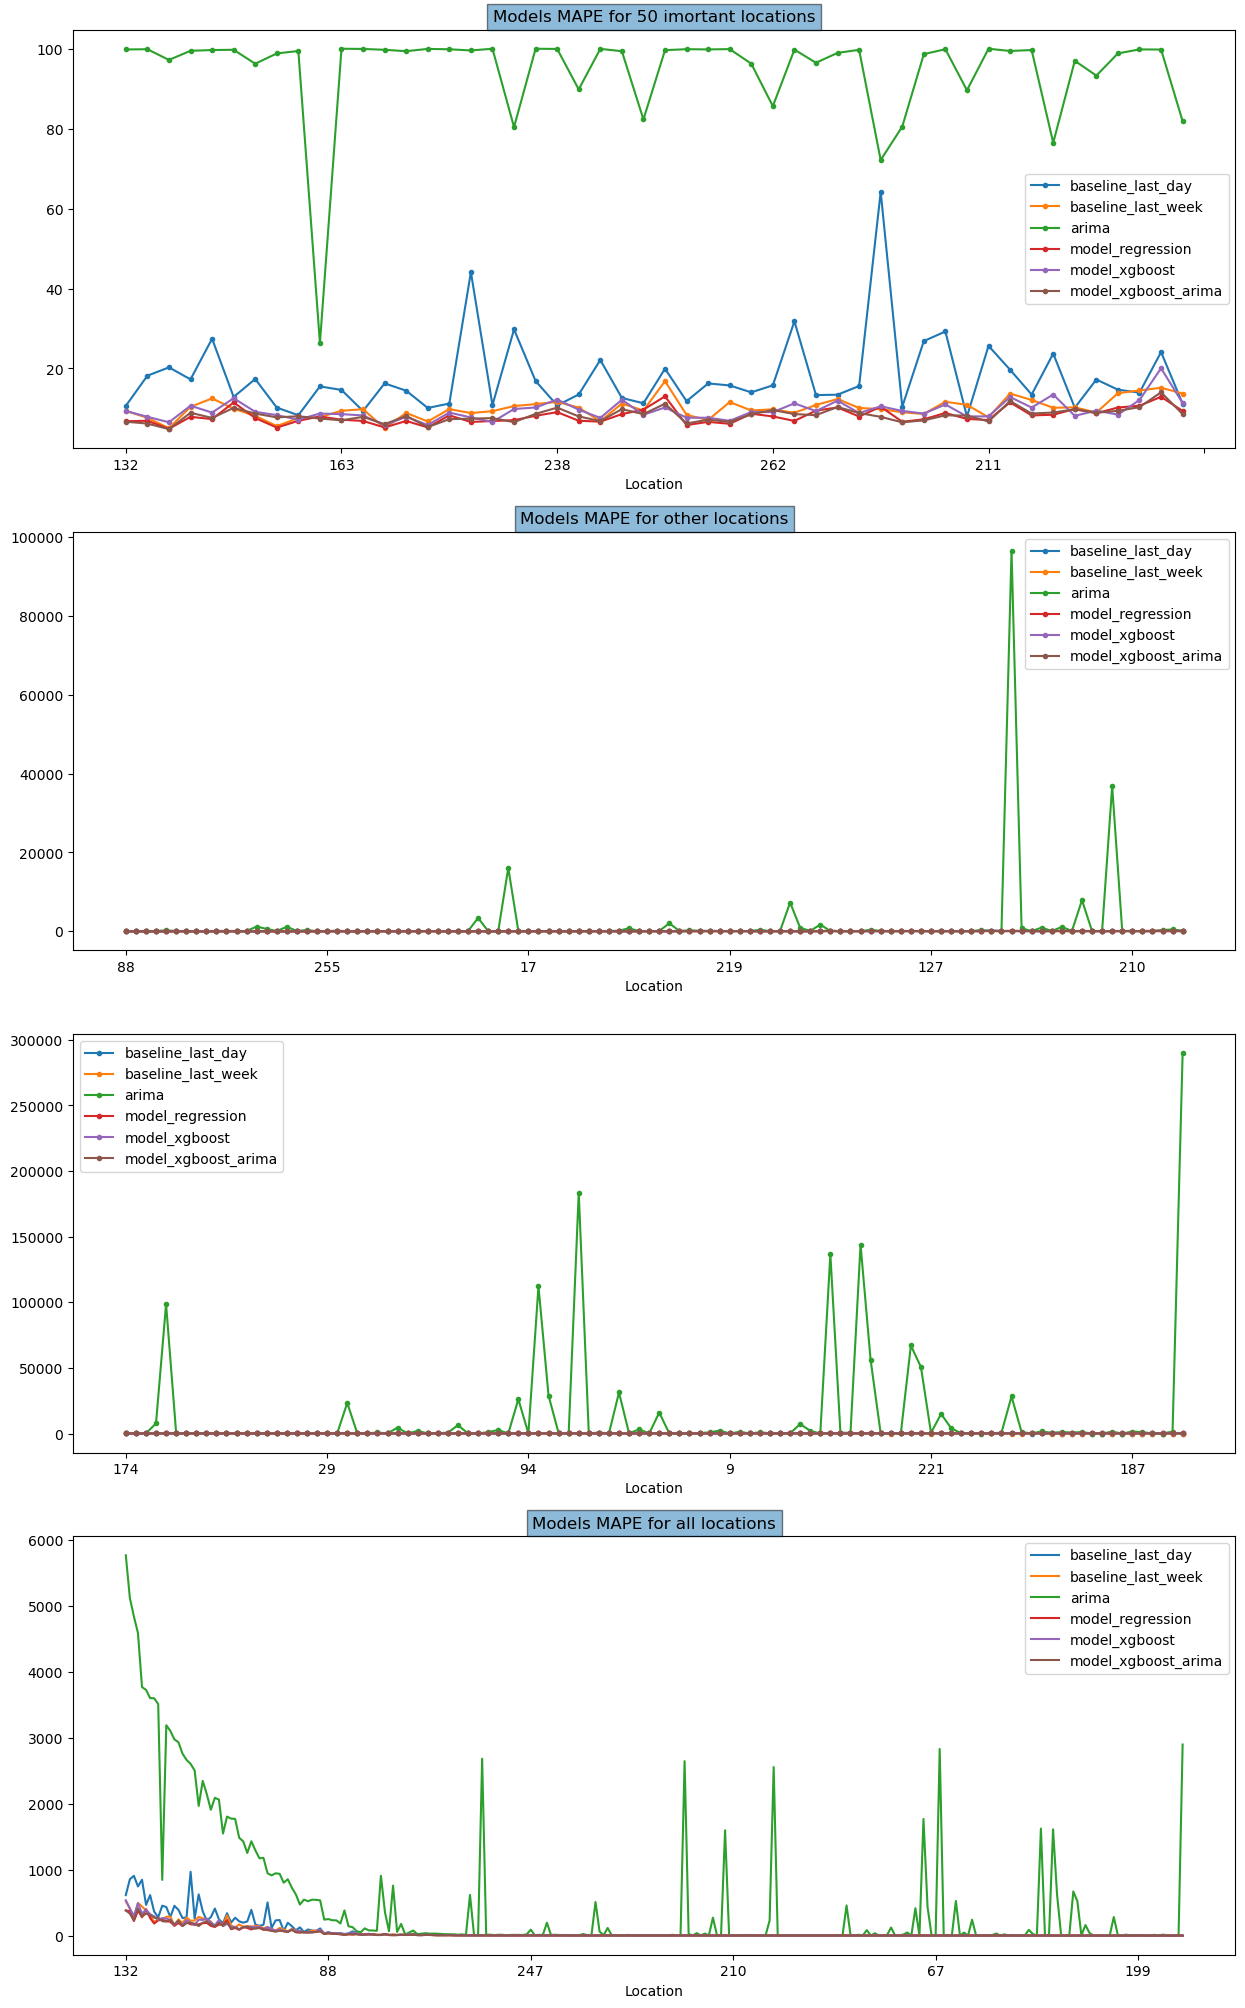

In [43]:
plot_mape(predictions_mean_error_dict, 'Location')

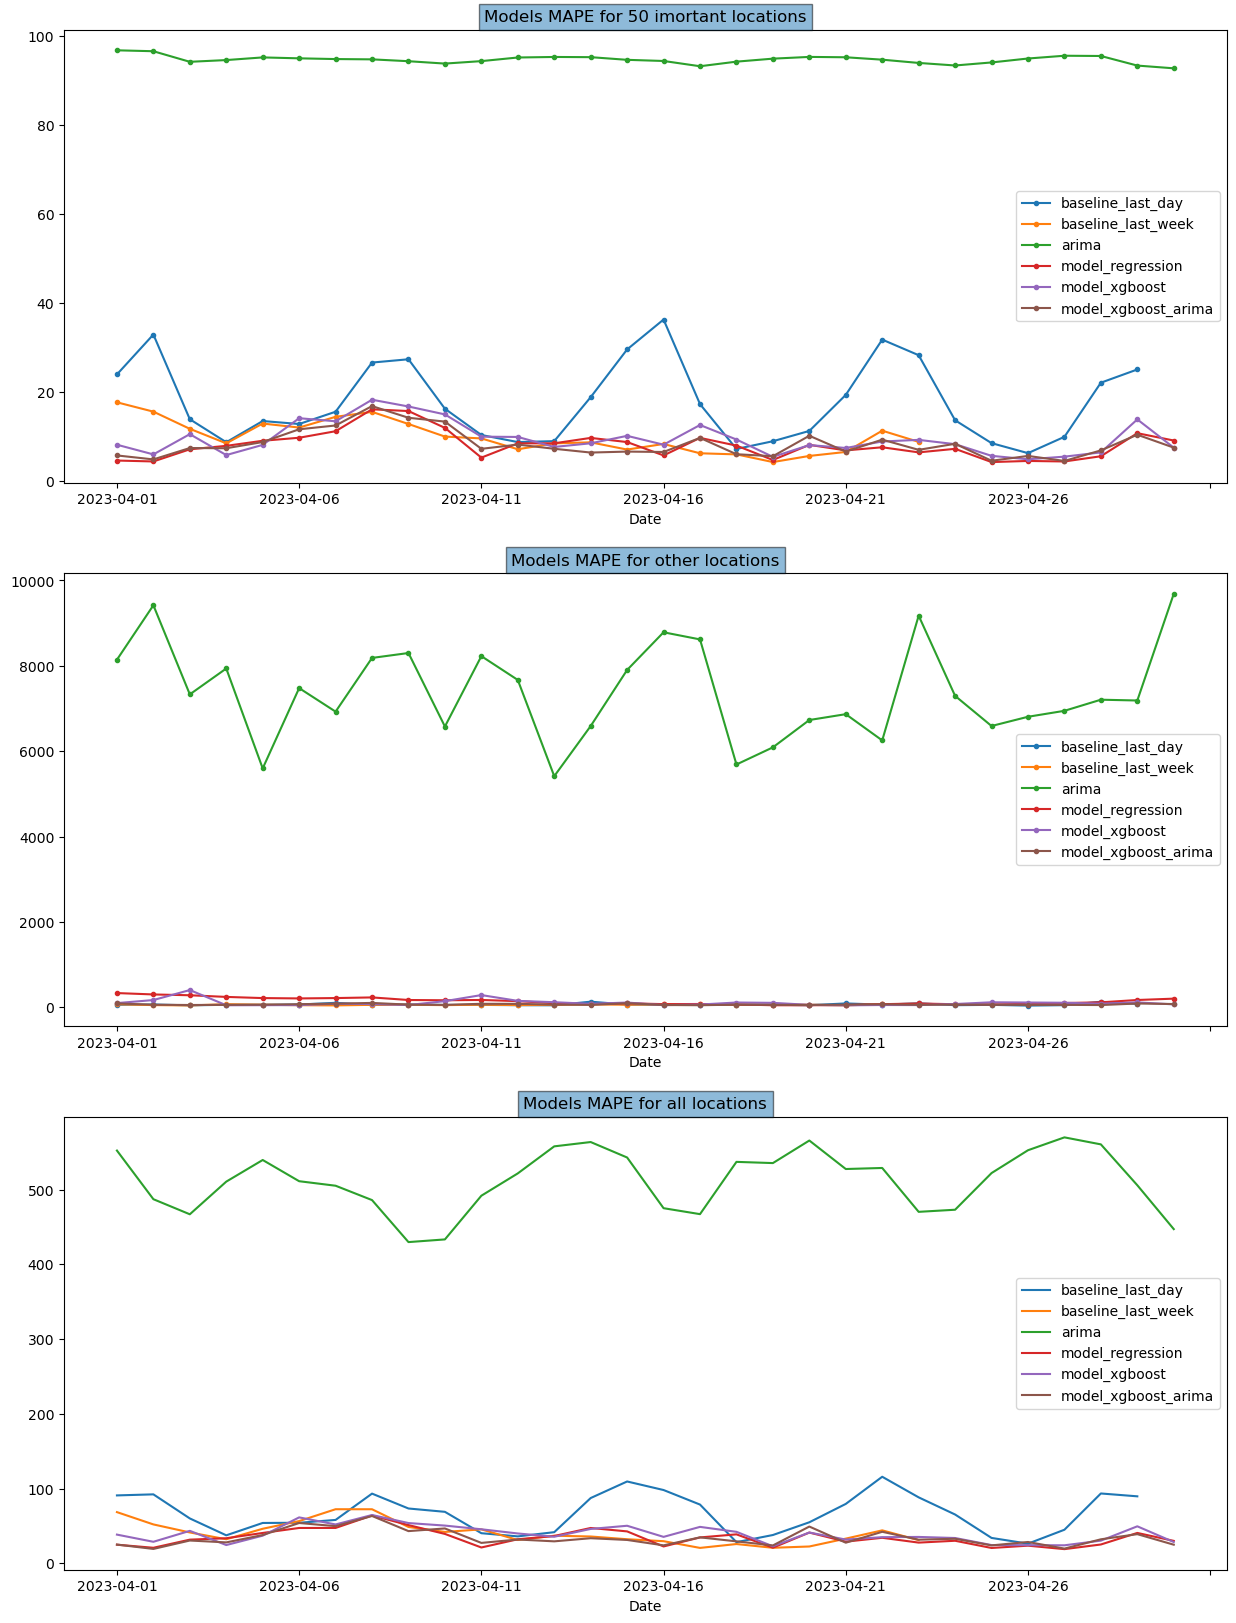

In [44]:
plot_mape(predictions_mean_error_dict, 'Date')

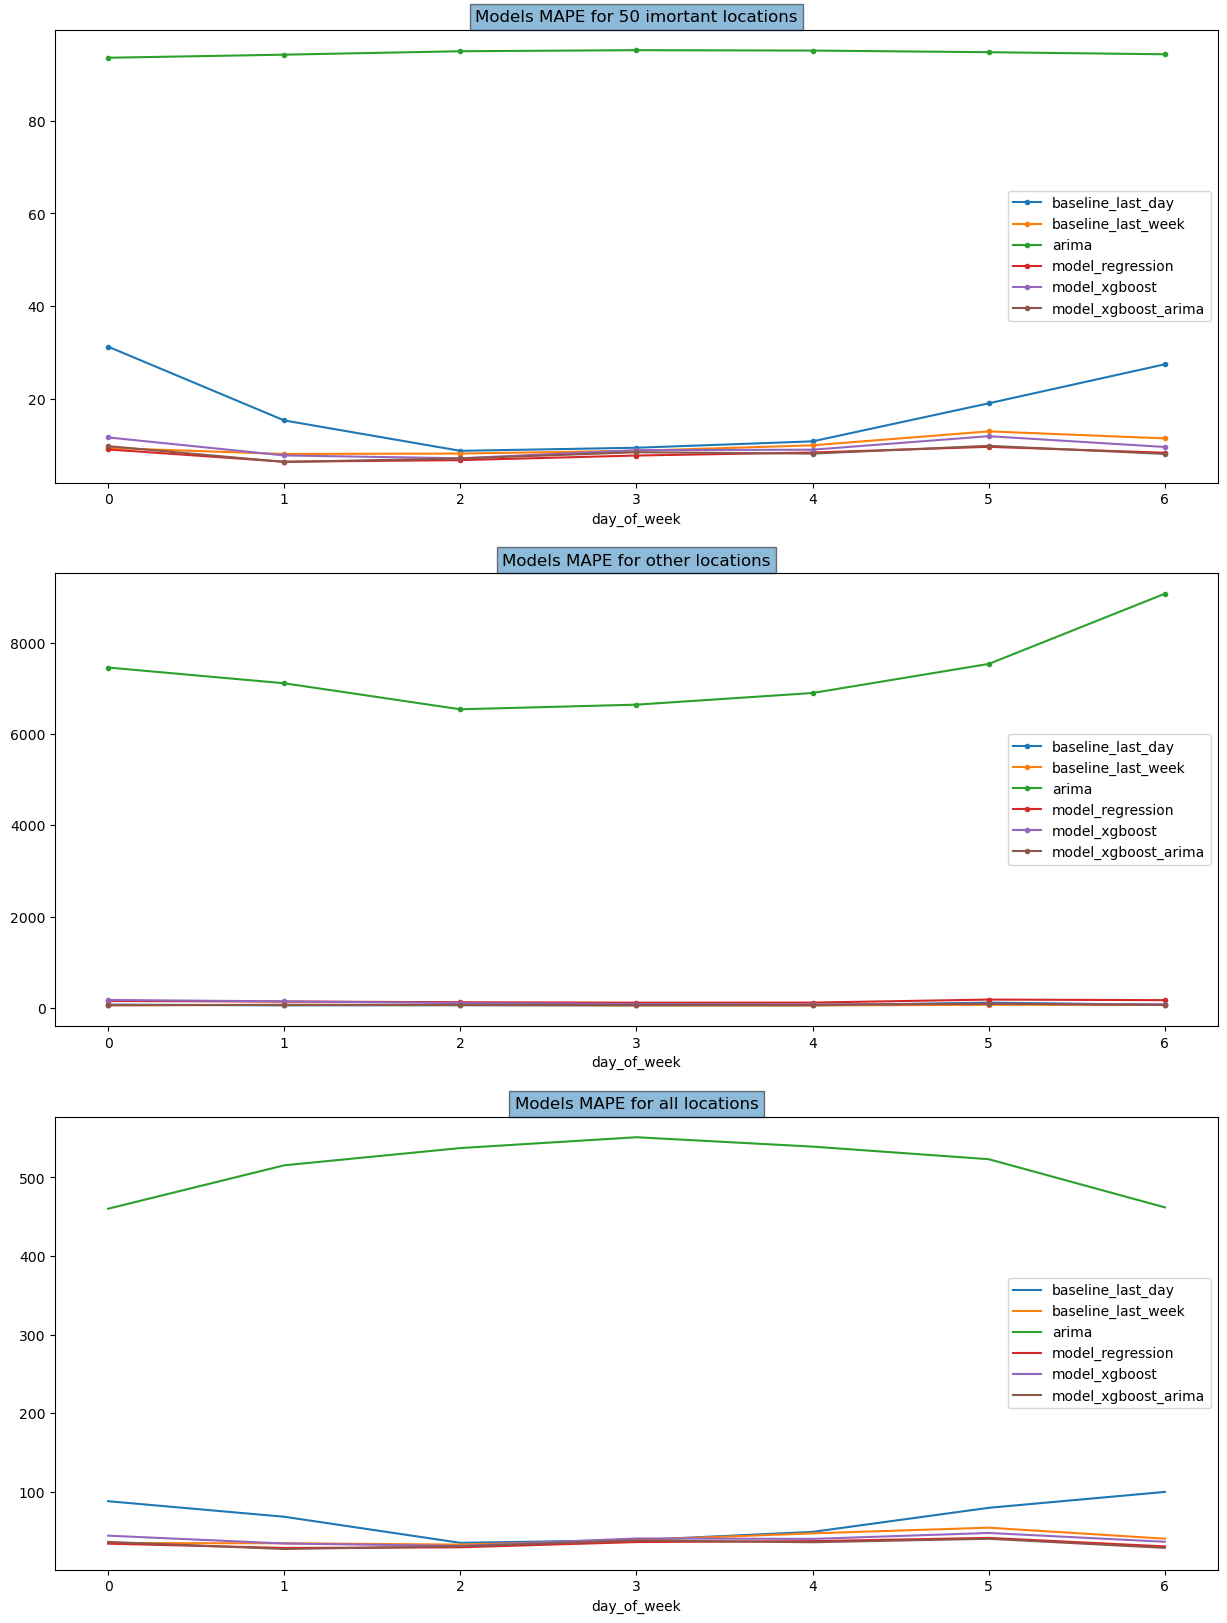

In [45]:
plot_mape(predictions_mean_error_dict, 'day_of_week')

### Plot MAE

In [47]:
def plot_mae(predictions_mean_dict, per):
    
    fig, axes = plt.subplots(nrows=(4 if (per == 'Location') else 3 ), ncols=1, figsize=((15,25)if (per == 'Location') else (15,20))) 

    
    for model,mean_df in predictions_mean_dict.items():
        important_df = mean_df[per]['Important_loc']
        other_df = mean_df[per]['Others_loc']
        all_df = mean_df[per]['All_loc']
        if (important_df is not None) and (other_df is not None) and (all_df is not None):

            important_df[per] = important_df[per].astype(str)
            other_df[per] = other_df[per].astype(str)
            all_df[per] = all_df[per].astype(str)
            
            important_df.plot(  x=per,y='mae',kind='line',ax = axes[0],label=model)
            if per == 'Location':
                split_size = len(other_df)//2
                other_df[:split_size].plot(x=per,y='mae',kind='line',ax = axes[1], label=model)
                other_df[split_size:].plot(x=per,y='mae',kind='line',ax = axes[2],label=model)
                all_df.plot(x=per,y='mae',kind='line',ax = axes[3],label=model)
            else:
                other_df.plot(x=per,y='mae',kind='line',ax = axes[1],label=model)
                all_df.plot(x=per,y='mae',kind='line',ax = axes[2],label=model)


    # plot demand mean to compare with MAE
    for model,mean_df in predictions_mean_dict.items():
        important_df = mean_df[per]['Important_loc']
        other_df = mean_df[per]['Others_loc']
        all_df = mean_df[per]['All_loc']
        if (important_df is not None) and (other_df is not None) and (all_df is not None):

            important_df[per] = important_df[per].astype(str)
            other_df[per] = other_df[per].astype(str)
            all_df[per] = all_df[per].astype(str)
            
            important_df.plot(x=per,y='demand_mean',kind='line',marker='.',ax = axes[0],label='demand_mean')
            if per == 'Location':
                split_size = len(other_df)//2
                other_df[:split_size].plot(x=per,y='demand_mean',kind='line',marker='.',ax = axes[1],label='demand_mean')
                other_df[split_size:].plot(x=per,y='demand_mean',kind='line',marker='.',ax = axes[2],label='demand_mean')
                all_df.plot(x=per,y='demand_mean',kind='line',marker='.',ax = axes[3],label='demand_mean')

            else:
                other_df.plot(x=per,y='demand_mean',kind='line',marker='.',ax = axes[1],label='demand_mean')
                all_df.plot(x=per,y='demand_mean',kind='line',marker='.',ax = axes[2],label='demand_mean')
            break
        
    axes[0].set_title('Models MAE for '+str(IMPORTANT_LOCATIONS)+' imortant locations', bbox=dict( alpha=0.5)) 
    axes[1].set_title('Models MAE for other locations', bbox=dict(alpha=0.5)) 
    axes[-1].set_title('Models MAE for all locations', bbox=dict(alpha=0.5)) 


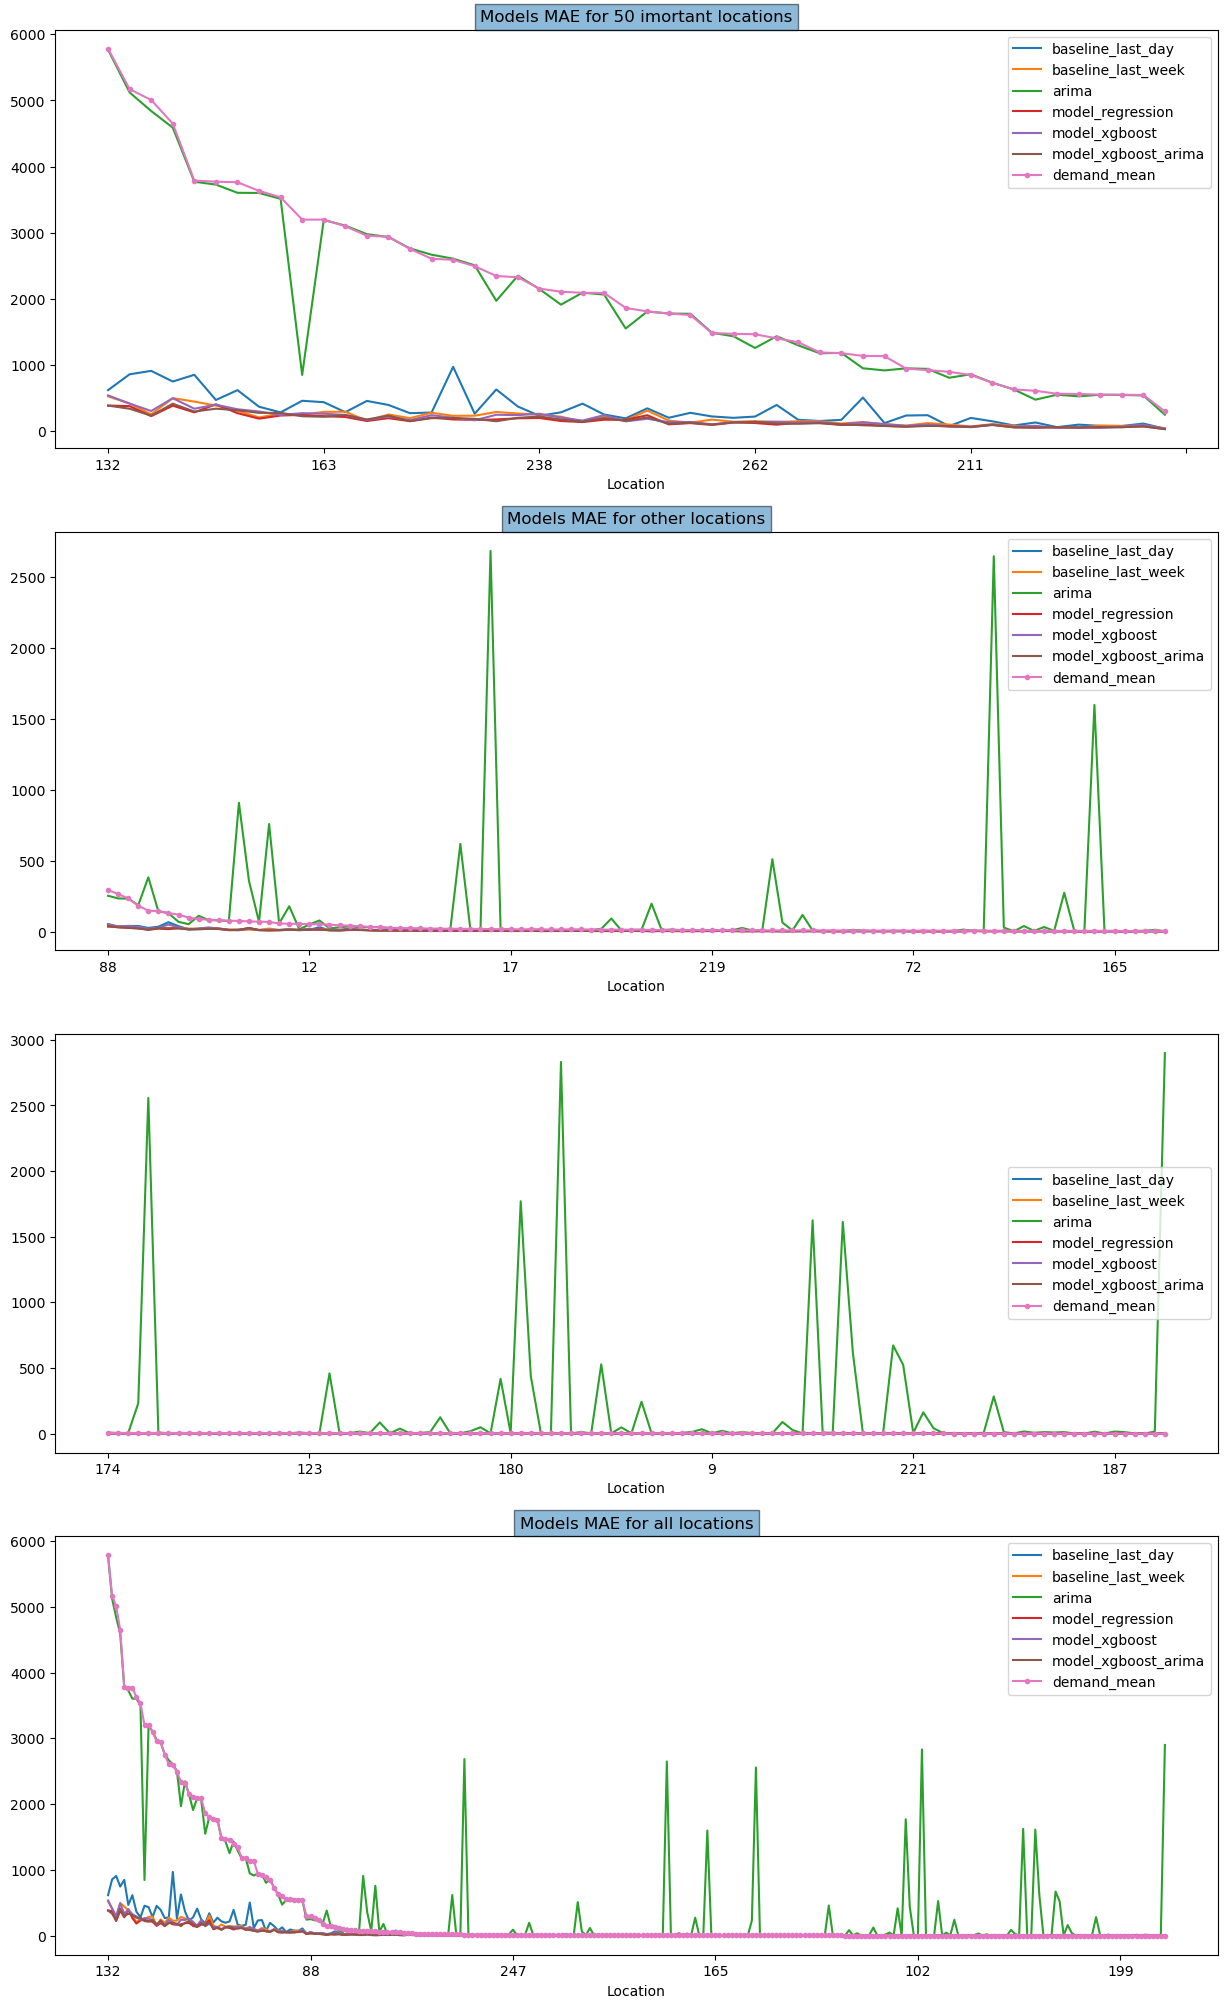

In [48]:
plot_mae(predictions_mean_error_dict, 'Location')

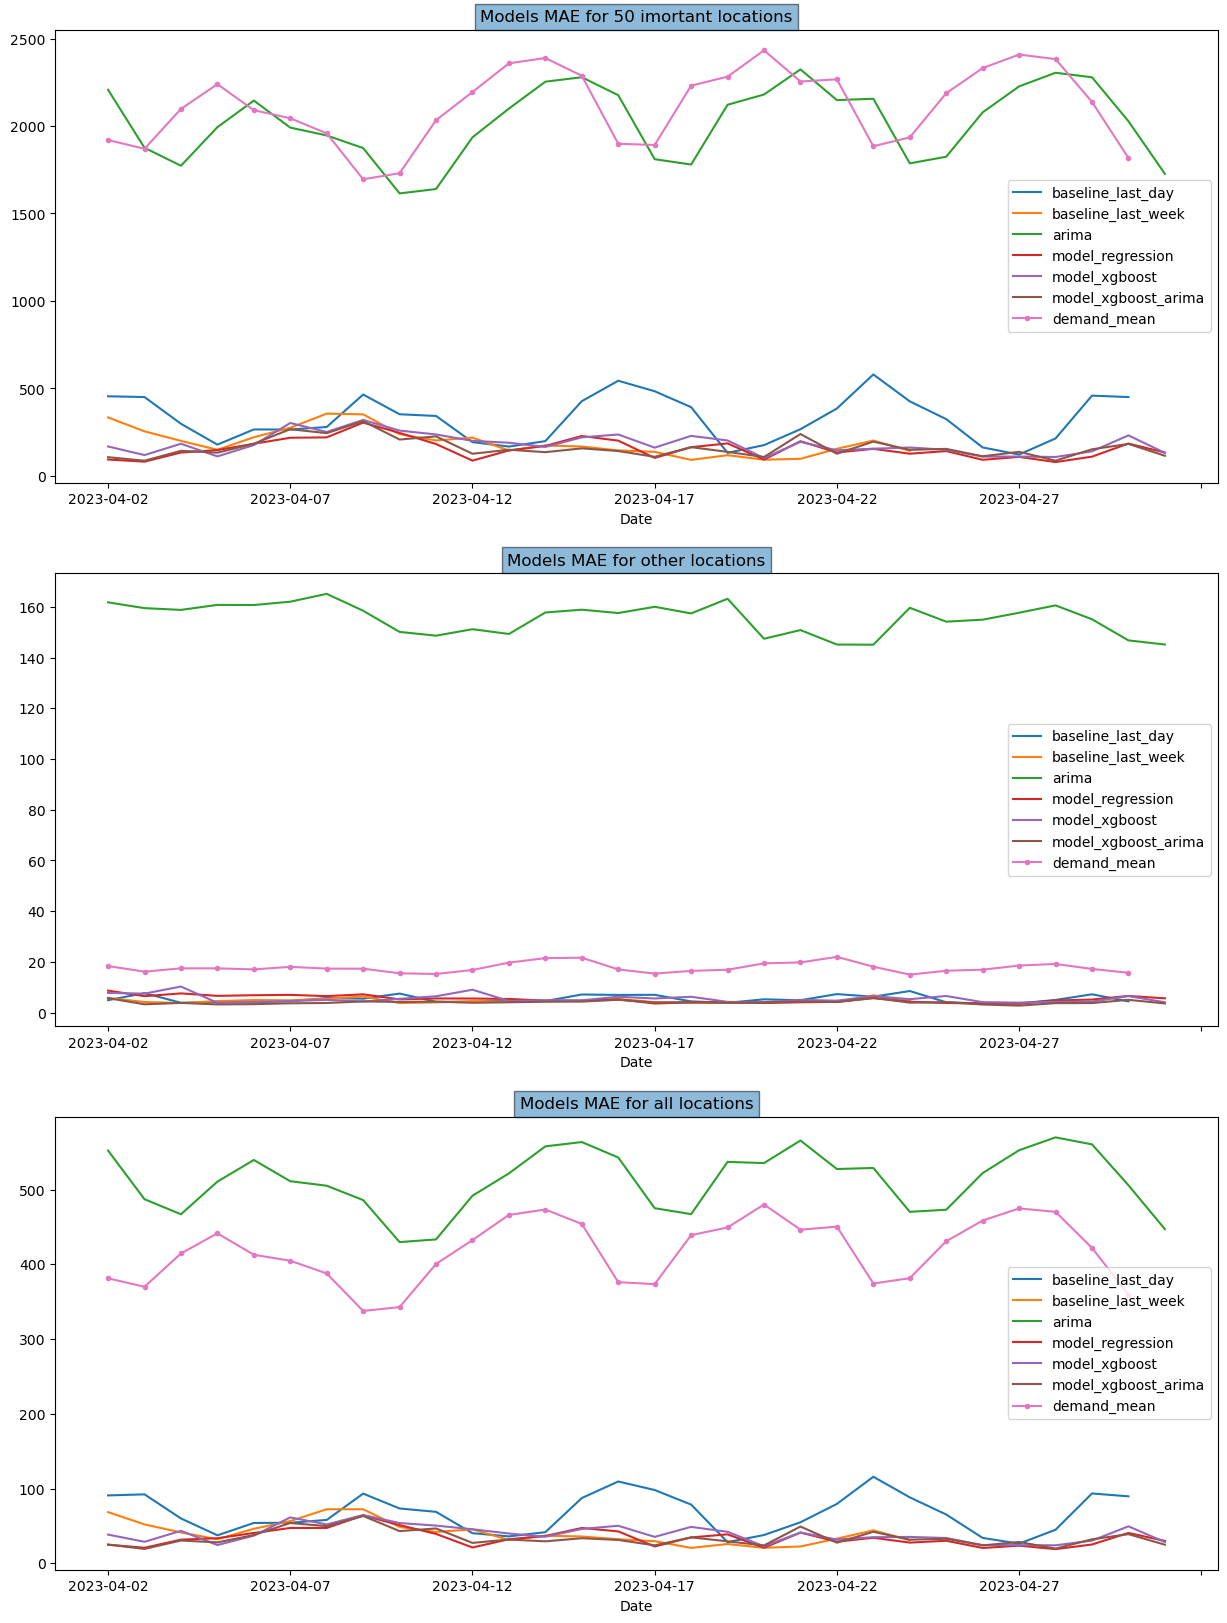

In [49]:
plot_mae(predictions_mean_error_dict, 'Date')

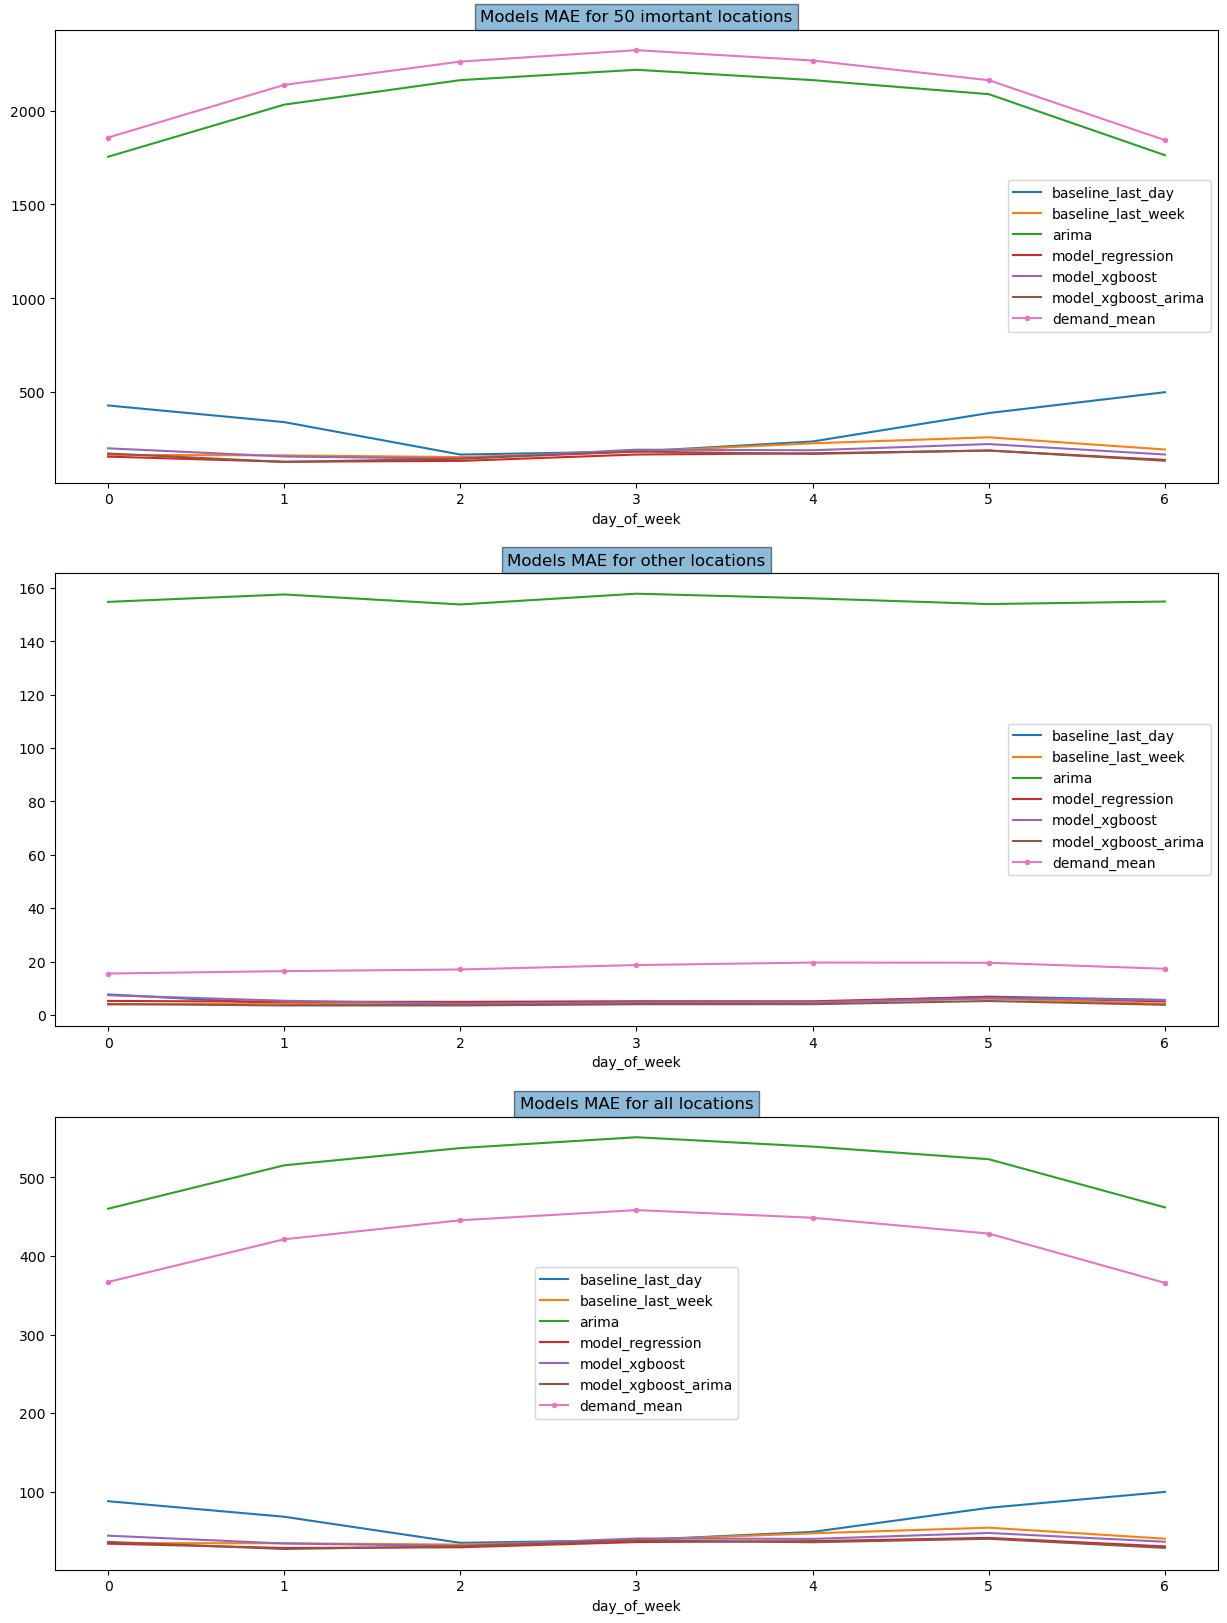

In [50]:
plot_mae(predictions_mean_error_dict, 'day_of_week')